**COVID-19 Analysis**

Wally Estenson (westenson@wisc.edu), Michael Marotta (mmarotta@wisc.edu)
Project Group 29

**Setup**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt  
import geopandas                         
from shapely.geometry import Point 
import seaborn as sns 

import sklearn.cluster
import statsmodels.api as sm
import sklearn

from mpl_toolkits.axes_grid1 import make_axes_locatable

import statsmodels.formula.api as smf  
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model                         
from sklearn.preprocessing import StandardScaler   


Color map options
https://matplotlib.org/tutorials/colors/colormaps.html

**Files needed:**

cb_2018_us_county_5m zip
- https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

covid19 deaths by county USA
- https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv

US Census Data
- General Population
 - https://covid19-uscensus.hub.arcgis.com/datasets/acs-total-population-county?geometry=-131.696%2C-0.672%2C132.327%2C76.524

- Housing
    - https://covid19-uscensus.hub.arcgis.com/datasets/acs-highlights-population-housing-basics-county-centroids?geometry=110.373%2C26.199%2C17.385%2C65.984
    
- Internet Connectivity 
    - https://covid19-uscensus.hub.arcgis.com/datasets/acs-internet-connectivity-county?geometry=-133.190%2C28.795%2C133.821%2C67.148
    
- Health Insurance Coverage 
    - https://covid19-uscensus.hub.arcgis.com/datasets/acs-health-insurance-coverage-county?geometry=-133.190%2C28.795%2C133.821%2C67.148


**Load County Geometry for Map Creation**

In [2]:
counties = geopandas.read_file('cb_2018_us_county_5m/cb_2018_us_county_5m.shp')

In [3]:
counties['GEOID'] = counties['GEOID'].astype('int64')

In [4]:
#ALAND is square meters, GEOID is FIPS 
columns = ["GEOID", "NAME", "ALAND", "geometry"]
counties = counties[columns]
counties.head(10)

,GEOID,NAME,ALAND,geometry
0,39071,Highland,1432479992,"POLYGON ((-83.86976 39.05553, -83.86568 39.247..."
1,6003,Alpine,1912292630,"POLYGON ((-120.07248 38.50987, -120.07239 38.7..."
2,12033,Escambia,1701544502,"POLYGON ((-87.62999 30.87766, -87.62946 30.880..."
3,17101,Lawrence,963936864,"POLYGON ((-87.91028 38.57493, -87.90811 38.850..."
4,28153,Wayne,2099745573,"POLYGON ((-88.94317 31.78421, -88.94335 31.824..."
5,28141,Tishomingo,1098938845,"POLYGON ((-88.36567 34.79942, -88.36353 34.995..."
6,30089,Sanders,7149405165,"POLYGON ((-116.04967 48.21612, -116.01672 48.2..."
7,36001,Albany,1354120790,"POLYGON ((-74.26486 42.41986, -74.24446 42.470..."
8,42105,Potter,2800612694,"POLYGON ((-78.20660 41.99962, -78.12473 42.000..."
9,29077,Greene,1749081115,"POLYGON ((-93.62115 37.42742, -93.43723 37.423..."


In [5]:
# Change the projection to Mercador
counties = counties.to_crs({'init': 'epsg:3395'}) 

C:\Users\Wally\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


**Loading and Organizing Coronavirus Data**

In [6]:

#covid19_global_cases_ts = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
covid19_us_cases_ts = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
covid19_us_deaths_ts = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"


#create data frame about US deaths by county
covid_us_deaths_df = pd.read_csv(covid19_us_deaths_ts)
covid_us_cases_df = pd.read_csv(covid19_us_cases_ts)

In [7]:
#for our analysis, we will focus total deaths as of 4/28
columns = ["Province_State", "FIPS", "4/28/20"]
us_deaths_428 = covid_us_deaths_df[columns]
us_cases_428 = covid_us_cases_df[columns]

us_deaths_428.rename(columns={"4/28/20":"Deaths"}, inplace=True)
us_cases_428.rename(columns={"4/28/20":"Cases"}, inplace=True)

us_deaths_428.head(10)

C:\Users\Wally\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,Province_State,FIPS,Deaths
0,American Samoa,60.0,0
1,Guam,66.0,5
2,Northern Mariana Islands,69.0,2
3,Puerto Rico,72.0,86
4,Virgin Islands,78.0,4
5,Alabama,1001.0,4
6,Alabama,1003.0,3
7,Alabama,1005.0,0
8,Alabama,1007.0,0
9,Alabama,1009.0,0


In [8]:
us_428 = pd.merge(left=counties, right = us_deaths_428, left_on="GEOID", 
                         right_on = "FIPS", how="inner", indicator=False)

In [9]:
us_428 = pd.merge(left=us_428, right = us_cases_428, left_on="GEOID", 
                         right_on = "FIPS", how="inner", indicator=False)

In [10]:
us_428.drop(["FIPS_x","FIPS_y", "Province_State_y"],axis=1, inplace=True)

In [11]:
us_428 = us_428[us_428["Province_State_x"] != 'Alaska']
us_428 = us_428[us_428["Province_State_x"] != 'Hawaii']

us_428

,GEOID,NAME,ALAND,geometry,Province_State_x,Deaths,Cases
0,39071,Highland,1432479992,"POLYGON ((-9336339.199 4702702.359, -9335884.6...",Ohio,0,10
1,6003,Alpine,1912292630,"POLYGON ((-13366407.777 4625096.999, -13366397...",California,0,2
2,12033,Escambia,1701544502,"POLYGON ((-9754926.191 3594945.126, -9754866.8...",Florida,11,485
3,17101,Lawrence,963936864,"POLYGON ((-9786127.828 4634319.101, -9785886.3...",Illinois,0,3
4,28153,Wayne,2099745573,"POLYGON ((-9901108.283 3712514.847, -9901128.9...",Mississippi,0,19
...,...,...,...,...,...,...,...
3137,42055,Franklin,2000048804,"POLYGON ((-8693937.424 4798381.772, -8690634.2...",Pennsylvania,4,237
3138,12001,Alachua,2266324954,"POLYGON ((-9201508.008 3460483.867, -9200722.0...",Florida,2,255
3139,48247,Jim Hogg,2942674729,"POLYGON ((-11015583.365 3137597.678, -10998152...",Texas,0,3
3140,29099,Jefferson,1700345322,"POLYGON ((-10103669.124 4594778.429, -10102867...",Missouri,4,267


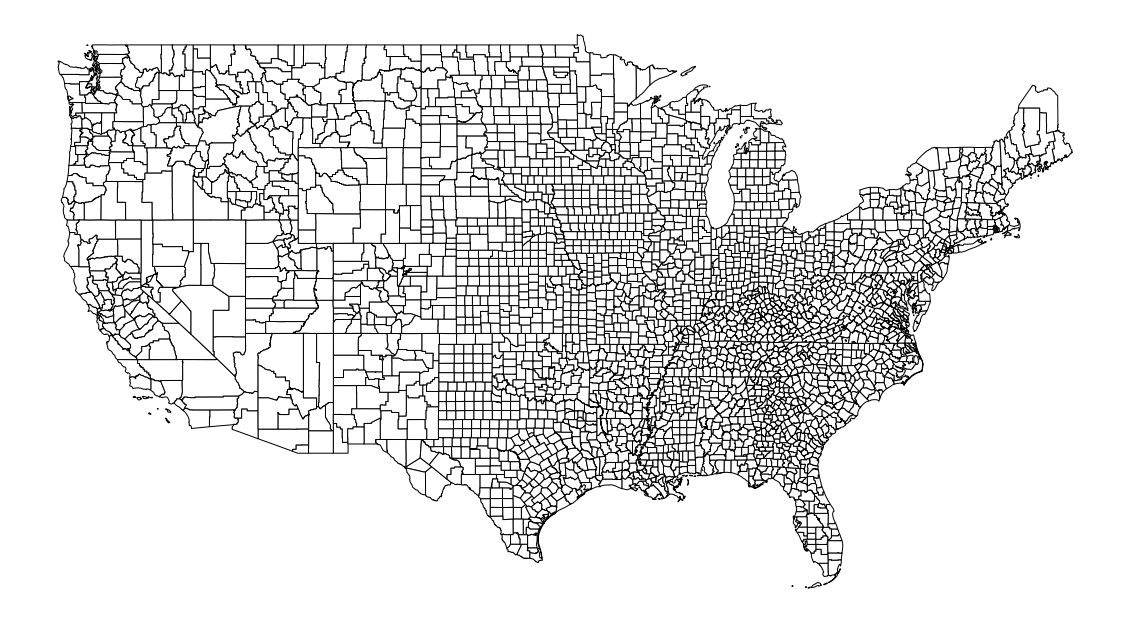

In [12]:
#check to make sure we can plot all counties with geometry data
fig, gax = plt.subplots(figsize=(20,40))

# Plot the counties
us_428.plot(ax=gax, edgecolor='black', color='White')

plt.axis('off')

plt.show()

**Loading and Organizing Demographic Data**

for US census data, see ASC217_Tables_Shells to see naming convections 

US Census General Population Data

In [13]:
columns = ["GEOID", "B01001_001E", "B01001_002E", "B01001_026E", "B01001_calc_pctGE65E"]

us_pop = "ACS_Total_Population__County.csv"
us_pop_df = pd.read_csv(us_pop, usecols=columns)

us_pop_df.rename(columns={"B01001_001E":"Population", "B01001_002E":"Males", 
                          "B01001_026E":"Females", "B01001_calc_pctGE65E": "Pct_65+"}, inplace=True)

us_pop_df.head(1)

,GEOID,Population,Males,Females,Pct_65+
0,54017,8536,4692,3844,20.1


US Census Housing Data

In [14]:
columns = ["GEOID", "B01002_001E", "B03002_calc_pctNHWhiteE", "B03002_calc_pctBlackE", "B03002_calc_pctAsianE", 
           "B03002_calc_pctHispLatE", "B19049_001E", "B25002_001E", "B25002_002E", "B25003_calc_pctOwnE", 
           "B25058_001E", "B25077_001E"]

us_housing = "ACS_Highlights_Population_Housing_Basics_-_County_Centroids.csv"
us_housing_df = pd.read_csv(us_housing, usecols=columns)

us_housing_df.rename(columns={"B01002_001E":"Median_Age", "B03002_calc_pctNHWhiteE":"Pct_White", 
                          "B03002_calc_pctBlackE":"Pct_Black", "B03002_calc_pctAsianE":"Pct_Asian", 
                          "B03002_calc_pctHispLatE": "Pct_Latino", "B19049_001E": "Household_Income", 
                          "B25002_001E":"Housing_Units", "B25002_002E":"Occupied_Housing_Units", 
                          "B25003_calc_pctOwnE":"Home_Owernship_Rate", "B25058_001E":"Median_Rent", 
                          "B25077_001E":"Median_Home_Value"}, inplace=True)

us_housing_df.head(1)

,GEOID,Median_Age,Pct_White,Pct_Black,Pct_Asian,Pct_Latino,Household_Income,Housing_Units,Occupied_Housing_Units,Home_Owernship_Rate,Median_Rent,Median_Home_Value
0,1001,37.8,75.0,19.0,1.0,2.8,58786.0,23315,21115,74.9,770.0,147900.0


US Census Internet Connectivity Data

In [15]:
columns = ["GEOID", "B28001_calc_pctNoCompE", "B28002_calc_pctNoIntE"]

us_internet = "ACS_Internet_Connectivity_-_County.csv"
us_internet_df = pd.read_csv(us_internet, usecols=columns)

           
#Percents represent percent of households in county 
#Pct_NoComp is No computer, smartphone, or tablet 
us_internet_df.rename(columns={"B28001_calc_pctNoCompE":"Pct_NoComp", "B28002_calc_pctNoIntE":"Pct_NoInternet"}, inplace=True)

us_internet_df.head(1)

,GEOID,Pct_NoComp,Pct_NoInternet
0,1001,13.0,19.0


US Census Health Insurance Data

In [16]:
columns = ["GEOID", "B27010_calc_pctNoInsE", "B27010_calc_pctNoIns19to34E"]

us_health = "ACS_Health_Insurance_Coverage_-_County.csv"
us_health_df = pd.read_csv(us_health, usecols=columns)

us_health_df.rename(columns={"B27010_calc_pctNoInsE":"Pct_NoCoverage", "B27010_calc_pctNoIns19to34E":"Pct_NoCoverage_19to34"}, inplace=True)

us_health_df.head(1)

,GEOID,Pct_NoCoverage,Pct_NoCoverage_19to34
0,1001,7.1,13.9


Merging Data Frames

In [17]:
#merge the data frames

#data that is not in both is from US territories which we are not considering 
deaths_demographics = pd.merge(left= us_428, right=us_pop_df, left_on=["GEOID"], right_on=["GEOID"], how='inner', indicator=False)

deaths_demographics = pd.merge(left= deaths_demographics, right=us_housing_df, left_on=["GEOID"], right_on=["GEOID"], how='inner', indicator=False)
deaths_demographics = pd.merge(left= deaths_demographics, right=us_internet_df, left_on=["GEOID"], right_on=["GEOID"], how='inner', indicator=False)
deaths_demographics = pd.merge(left= deaths_demographics, right=us_health_df, left_on=["GEOID"], right_on=["GEOID"], how='inner', indicator=False)

deaths_demographics.head(1)


,GEOID,NAME,ALAND,geometry,Province_State_x,Deaths,Cases,Population,Males,Females,...,Household_Income,Housing_Units,Occupied_Housing_Units,Home_Owernship_Rate,Median_Rent,Median_Home_Value,Pct_NoComp,Pct_NoInternet,Pct_NoCoverage,Pct_NoCoverage_19to34
0,39071,Highland,1432479992,"POLYGON ((-9336339.199 4702702.359, -9335884.6...",Ohio,0,10,43007,21136,21871,...,43297.0,19326,16646,69.2,499.0,111700.0,20.1,28.4,8.6,17.7


In [18]:
#convert square meters to square kms 

deaths_demographics.rename(columns={"NAME":"County", "ALAND":"SqrKM", "Province_State":"State"}, inplace=True)
deaths_demographics["SqrKM"] = deaths_demographics["SqrKM"] / 1000000

deaths_demographics["Density"] = deaths_demographics["Population"] / deaths_demographics["SqrKM"]
deaths_demographics["DeathRate"] = deaths_demographics["Deaths"] / deaths_demographics["Cases"]

deaths_demographics.head(1)


,GEOID,County,SqrKM,geometry,Province_State_x,Deaths,Cases,Population,Males,Females,...,Occupied_Housing_Units,Home_Owernship_Rate,Median_Rent,Median_Home_Value,Pct_NoComp,Pct_NoInternet,Pct_NoCoverage,Pct_NoCoverage_19to34,Density,DeathRate
0,39071,Highland,1432.479992,"POLYGON ((-9336339.199 4702702.359, -9335884.6...",Ohio,0,10,43007,21136,21871,...,16646,69.2,499.0,111700.0,20.1,28.4,8.6,17.7,30.022758,0.0


**Scatter Plots**

In [19]:
#drop counties with no deaths
deaths_demographics["Deathsp100k"] = (deaths_demographics["Deaths"] / (deaths_demographics["Population"]/100000)) 
deaths_demographics["Casesp100k"] = (deaths_demographics["Cases"] / (deaths_demographics["Population"]/100000)) 

#to be used in plotting the entire united states - excluding new york county to build cholorpleths w/o outlier  
deaths_demographics_minusny = deaths_demographics.loc[deaths_demographics['County'] != "New York"]

#to be used in regression analysis 
deaths_demographics_drop = deaths_demographics[deaths_demographics['Deathsp100k'] > 15]
deaths_demographics_drop = deaths_demographics_drop.loc[deaths_demographics_drop['County'] != "New York"]

#to be used for scatter plots
deaths_demographics_drop2 = deaths_demographics[deaths_demographics['Casesp100k'] > 750]
deaths_demographics_drop2 = deaths_demographics_drop2.loc[deaths_demographics_drop2['County'] != "New York"]

#to be used for scatter plots
deaths_demographics_con = deaths_demographics[deaths_demographics['Deathsp100k'] > 0]
deaths_demographics_con = deaths_demographics_con[deaths_demographics_con['Casesp100k'] > 750]
deaths_demographics_con = deaths_demographics_con.loc[deaths_demographics_con['County'] != "New York"]


In [20]:
print(deaths_demographics.columns)

Index(['GEOID', 'County', 'SqrKM', 'geometry', 'Province_State_x', 'Deaths',
       'Cases', 'Population', 'Males', 'Females', 'Pct_65+', 'Median_Age',
       'Pct_White', 'Pct_Black', 'Pct_Asian', 'Pct_Latino', 'Household_Income',
       'Housing_Units', 'Occupied_Housing_Units', 'Home_Owernship_Rate',
       'Median_Rent', 'Median_Home_Value', 'Pct_NoComp', 'Pct_NoInternet',
       'Pct_NoCoverage', 'Pct_NoCoverage_19to34', 'Density', 'DeathRate',
       'Deathsp100k', 'Casesp100k'],
      dtype='object')


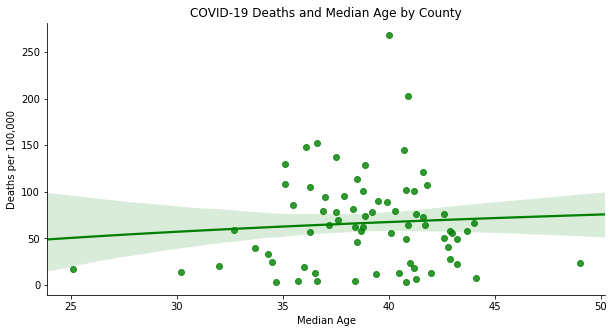

In [21]:
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

sns.regplot(x='Median_Age',
                                                  # column to put on x axis
            y= 'Deathsp100k',                     # column to put on y axis 
            data=deaths_demographics_con,         # the data
            ax = my_ax,                           # an axis object
            color = 'green',    
                  logx = True,
            ci = 90)                             # confidence interval, 0 supresses it


sns.despine(ax = my_ax)                             

# Since this is all in a matplotlib axis/figure, our usual labeling applies.  
my_ax.set_title('COVID-19 Deaths and Median Age by County')
my_ax.set_xlabel('Median Age')
my_ax.set_ylabel('Deaths per 100,000')

plt.show()

In [22]:
deaths_demographics_con.sort_values('Pct_65+', ascending=False).head(1)

,GEOID,County,SqrKM,geometry,Province_State_x,Deaths,Cases,Population,Males,Females,...,Median_Rent,Median_Home_Value,Pct_NoComp,Pct_NoInternet,Pct_NoCoverage,Pct_NoCoverage_19to34,Density,DeathRate,Deathsp100k,Casesp100k
2500,10005,Sussex,2424.543661,"POLYGON ((-8429423.179 4670533.250, -8410745.1...",Delaware,51,2114,219540,106429,113111,...,781.0,248900.0,12.3,18.5,7.1,16.2,90.548998,0.024125,23.230391,962.922474


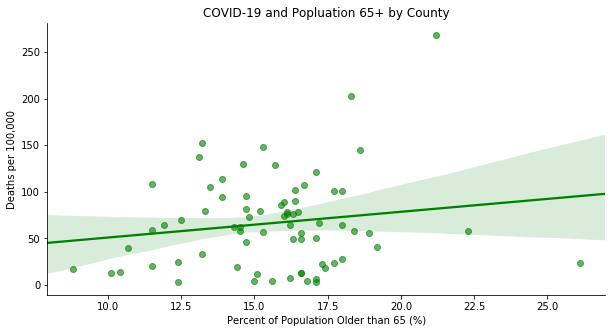

In [23]:
my_fig, my_ax = plt.subplots(figsize=(10,5)) 


my_kws={ 'alpha':0.6}

sns.regplot(x='Pct_65+',
                                                  # column to put on x axis
            y= 'Deathsp100k',                     # column to put on y axis 
            data=deaths_demographics_con,      # the data
            ax = my_ax,                           # an axis object
            color = 'green', 
            logx = False,
            scatter_kws = my_kws,
            ci = 90)                             # confidence interval, 0 supresses it


sns.despine(ax = my_ax)                             

# Since this is all in a matplotlib axis/figure, our usual labeling applies.  
my_ax.set_title('COVID-19 and Popluation 65+ by County')
my_ax.set_xlabel('Percent of Population Older than 65 (%)')
my_ax.set_ylabel('Deaths per 100,000')

plt.show()

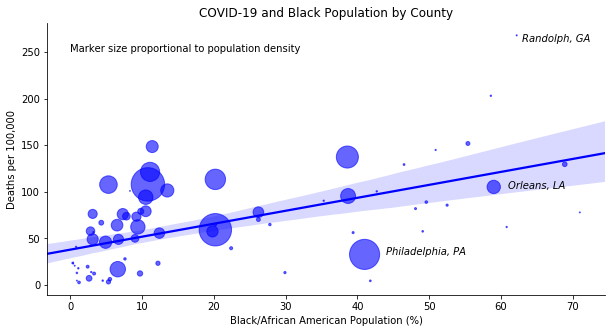

In [24]:
my_fig, my_ax = plt.subplots(figsize=(10,5)) 


my_kws={'s': deaths_demographics_con['Density']/5, 'alpha':0.6}

sns.regplot(x='Pct_Black',
                                                # column to put on x axis
            y= 'Deathsp100k',                   # column to put on y axis 
            data=deaths_demographics_con,       # the data
            ax = my_ax,                         # an axis object
            color = 'blue',  
            logx=False,
            scatter_kws = my_kws,
            ci = 90)                            # confidence interval, 0 supresses it


my_ax.text(0, 250, 'Marker size proportional to population density')   

my_ax.text(63, 261, 'Randolph, GA',  style="italic") 
my_ax.text(61, 103, 'Orleans, LA',  style="italic") 
my_ax.text(44, 32, 'Philadelphia, PA',  style="italic") 

sns.despine(ax = my_ax)                             

# Since this is all in a matplotlib axis/figure, our usual labeling applies.  
my_ax.set_title('COVID-19 and Black Population by County')
my_ax.set_xlabel('Black/African American Population (%)')
my_ax.set_ylabel('Deaths per 100,000')

plt.show()

In [25]:
deaths_demographics_con.sort_values('Pct_Black', ascending=False).head(1)

,GEOID,County,SqrKM,geometry,Province_State_x,Deaths,Cases,Population,Males,Females,...,Median_Rent,Median_Home_Value,Pct_NoComp,Pct_NoInternet,Pct_NoCoverage,Pct_NoCoverage_19to34,Density,DeathRate,Deathsp100k,Casesp100k
1145,28157,Wilkinson,1756.287147,"POLYGON ((-10199661.480 3611439.682, -10197587...",Mississippi,7,68,8990,4816,4174,...,322.0,70000.0,33.4,48.9,14.8,29.4,5.118753,0.102941,77.864294,756.395996


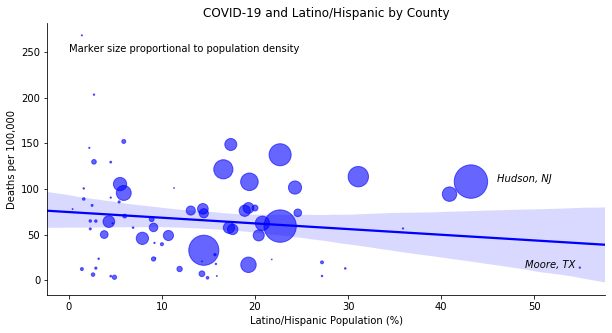

In [26]:
my_fig, my_ax = plt.subplots(figsize=(10,5)) 


my_kws={'s': deaths_demographics_con['Density']/5, 'alpha':0.6}

sns.regplot(x='Pct_Latino',
                                                # column to put on x axis
            y= 'Deathsp100k',                   # column to put on y axis 
            data=deaths_demographics_con,       # the data
            ax = my_ax,                         # an axis object
            color = 'blue',  
            logx=False,
            scatter_kws = my_kws,
            ci = 90)                            # confidence interval, 0 supresses it


my_ax.text(0, 250, 'Marker size proportional to population density')    
sns.despine(ax = my_ax)       

my_ax.text(49, 13.7, 'Moore, TX',  style="italic") 
my_ax.text(46, 108, 'Hudson, NJ',  style="italic") 

# Since this is all in a matplotlib axis/figure, our usual labeling applies.  
my_ax.set_title('COVID-19 and Latino/Hispanic by County')
my_ax.set_xlabel('Latino/Hispanic Population (%)')
my_ax.set_ylabel('Deaths per 100,000')

plt.show()

In [27]:
deaths_demographics_con.sort_values('Pct_Latino', ascending=False).head(1)

,GEOID,County,SqrKM,geometry,Province_State_x,Deaths,Cases,Population,Males,Females,...,Median_Rent,Median_Home_Value,Pct_NoComp,Pct_NoInternet,Pct_NoCoverage,Pct_NoCoverage_19to34,Density,DeathRate,Deathsp100k,Casesp100k
502,48341,Moore,2330.207187,"POLYGON ((-11372734.808 4283076.402, -11312672...",Texas,3,294,21801,11438,10363,...,571.0,115100.0,13.3,18.8,16.6,27.9,9.35582,0.010204,13.760837,1348.561993


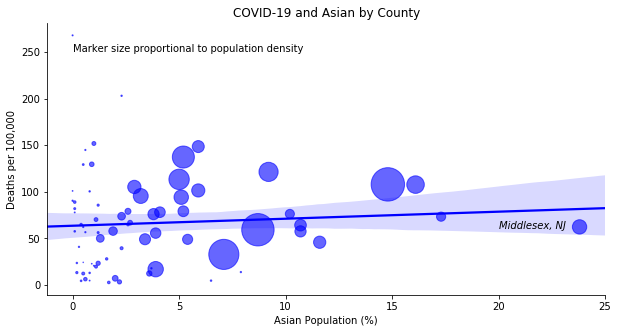

In [28]:
my_fig, my_ax = plt.subplots(figsize=(10,5)) 


my_kws={'s': deaths_demographics_con['Density']/5, 'alpha':0.6}

sns.regplot(x='Pct_Asian',
                                                # column to put on x axis
            y= 'Deathsp100k',                   # column to put on y axis 
            data=deaths_demographics_con,       # the data
            ax = my_ax,                         # an axis object
            color = 'blue',  
            logx=False,
            scatter_kws = my_kws,
            ci = 90)                            # confidence interval, 0 supresses it

my_ax.text(0, 250, 'Marker size proportional to population density')   

my_ax.text(20, 60, 'Middlesex, NJ',  style="italic") 
    
    
sns.despine(ax = my_ax)                                    

# Since this is all in a matplotlib axis/figure, our usual labeling applies.  
my_ax.set_title('COVID-19 and Asian by County')
my_ax.set_xlabel('Asian Population (%)')
my_ax.set_ylabel('Deaths per 100,000')

plt.show()

In [29]:
deaths_demographics_con.sort_values('Pct_Asian', ascending=False).head(1)

,GEOID,County,SqrKM,geometry,Province_State_x,Deaths,Cases,Population,Males,Females,...,Median_Rent,Median_Home_Value,Pct_NoComp,Pct_NoInternet,Pct_NoCoverage,Pct_NoCoverage_19to34,Density,DeathRate,Deathsp100k,Casesp100k
2855,34023,Middlesex,800.871212,"POLYGON ((-8307432.292 4889519.504, -8307151.2...",New Jersey,515,11102,826698,407247,419451,...,1304.0,336200.0,8.6,10.7,7.6,12.7,1032.248366,0.046388,62.296026,1342.932969


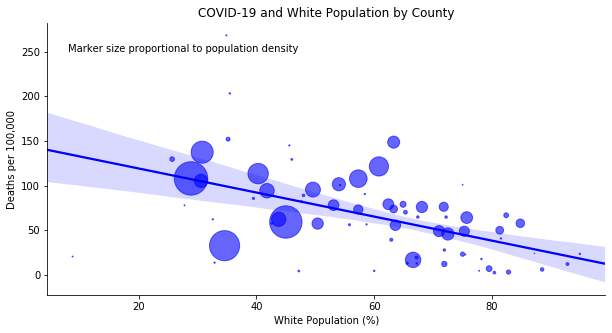

In [30]:
my_fig, my_ax = plt.subplots(figsize=(10,5)) 


my_kws={'s': deaths_demographics_con['Density']/5, 'alpha':0.6}

sns.regplot(x='Pct_White',
                                                # column to put on x axis
            y= 'Deathsp100k',                   # column to put on y axis 
            data=deaths_demographics_con,       # the data
            ax = my_ax,                         # an axis object
            color = 'blue',  
            logx=False,
            scatter_kws = my_kws,
            ci = 90)                            # confidence interval, 0 supresses it


my_ax.text(8, 250, 'Marker size proportional to population density')        
sns.despine(ax = my_ax)  

# Since this is all in a matplotlib axis/figure, our usual labeling applies.  
my_ax.set_title('COVID-19 and White Population by County')
my_ax.set_xlabel('White Population (%)')
my_ax.set_ylabel('Deaths per 100,000')


plt.show()

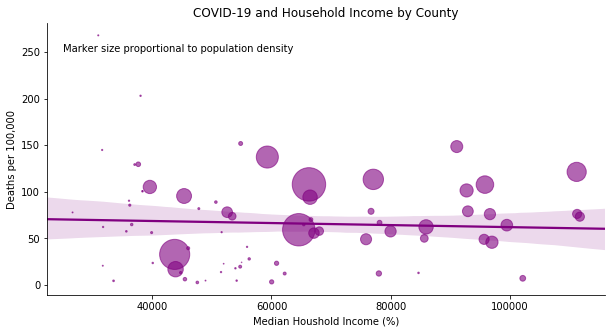

In [31]:
my_fig, my_ax = plt.subplots(figsize=(10,5)) 


my_kws={ 's': deaths_demographics_con['Density']/5, 'alpha':0.6}

sns.regplot(x='Household_Income',
                                                # column to put on x axis
            y= 'Deathsp100k',                   # column to put on y axis 
            data=deaths_demographics_con,       # the data
            ax = my_ax,                         # an axis object
            color = 'Purple',  
            logx=False,
            scatter_kws = my_kws,
            ci = 90)                            # confidence interval, 0 supresses it
 

my_ax.text(25000, 250, 'Marker size proportional to population density')  
sns.despine(ax = my_ax)                             



# Since this is all in a matplotlib axis/figure, our usual labeling applies.  
my_ax.set_title('COVID-19 and Household Income by County')
my_ax.set_xlabel('Median Houshold Income (%)')
my_ax.set_ylabel('Deaths per 100,000')

plt.show()

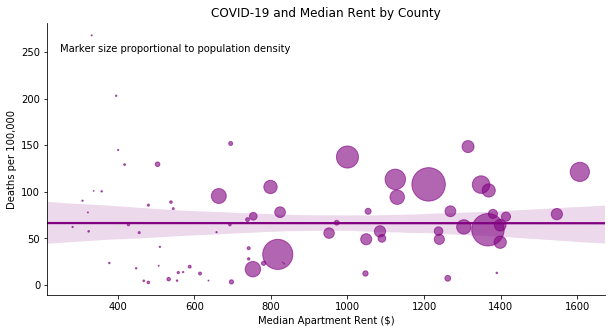

In [32]:
my_fig, my_ax = plt.subplots(figsize=(10,5)) 


my_kws={ 's': deaths_demographics_con['Density']/5,'alpha':0.6}

sns.regplot(x='Median_Rent',
                                                # column to put on x axis
            y= 'Deathsp100k',                     # column to put on y axis 
            data=deaths_demographics_con,       # the data
            ax = my_ax,                         # an axis object
            color = 'Purple',  
            logx=False,
            scatter_kws = my_kws,
            ci = 90)                            # confidence interval, 0 supresses it
 

my_ax.text(250, 250, 'Marker size proportional to population density')  
sns.despine(ax = my_ax)                             

# Since this is all in a matplotlib axis/figure, our usual labeling applies.  
my_ax.set_title('COVID-19 and Median Rent by County')
my_ax.set_xlabel('Median Apartment Rent ($)')
my_ax.set_ylabel('Deaths per 100,000')

plt.show()

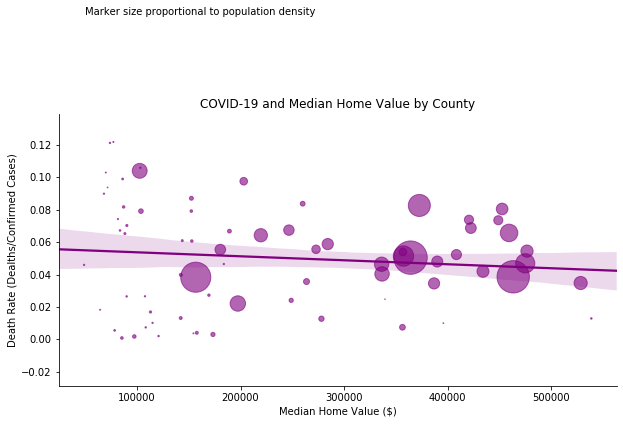

In [33]:
my_fig, my_ax = plt.subplots(figsize=(10,5)) 


my_kws={'s': deaths_demographics_con['Density']/5,  'alpha':0.6}

sns.regplot(x='Median_Home_Value',
                                                # column to put on x axis
            y= 'DeathRate',                     # column to put on y axis 
            data=deaths_demographics_con,       # the data
            ax = my_ax,                         # an axis object
            color = 'Purple',  
            logx=False,
            scatter_kws = my_kws,
            ci = 90)                            # confidence interval, 0 supresses it
 
my_ax.text(50000, .2, 'Marker size proportional to population density')  

sns.despine(ax = my_ax)                             

# Since this is all in a matplotlib axis/figure, our usual labeling applies.  
my_ax.set_title('COVID-19 and Median Home Value by County')
my_ax.set_xlabel('Median Home Value ($)')
my_ax.set_ylabel('Death Rate (Dealths/Confirmed Cases)')

plt.show()

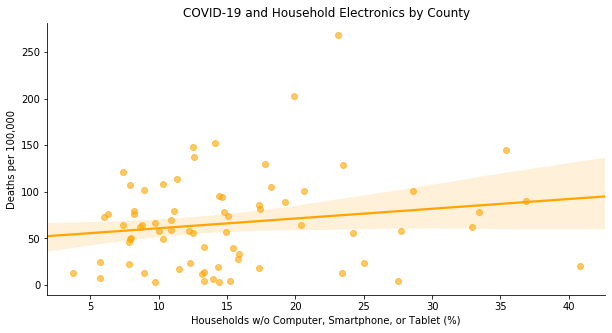

In [34]:
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

#densitiy relationship clear but doesnt look good on graph

my_kws={ 'alpha':0.6}

sns.regplot(x='Pct_NoComp',
                                                # column to put on x axis
            y= 'Deathsp100k',                     # column to put on y axis 
            data=deaths_demographics_con,       # the data
            ax = my_ax,                         # an axis object
            color = 'Orange',  
            logx=False,
            scatter_kws = my_kws,
            ci = 90)                            # confidence interval, 0 supresses it
 


sns.despine(ax = my_ax)        


# Since this is all in a matplotlib axis/figure, our usual labeling applies.  
my_ax.set_title('COVID-19 and Household Electronics by County')
my_ax.set_xlabel('Households w/o Computer, Smartphone, or Tablet (%)')
my_ax.set_ylabel('Deaths per 100,000')

plt.show()

In [35]:
deaths_demographics_con.sort_values('Pct_NoComp', ascending=False).head(1)

,GEOID,County,SqrKM,geometry,Province_State_x,Deaths,Cases,Population,Males,Females,...,Median_Rent,Median_Home_Value,Pct_NoComp,Pct_NoInternet,Pct_NoCoverage,Pct_NoCoverage_19to34,Density,DeathRate,Deathsp100k,Casesp100k
43,35031,McKinley,14117.193197,"POLYGON ((-12139033.803 4188673.850, -12138998...",New Mexico,15,820,72849,35158,37691,...,507.0,64500.0,40.8,52.7,20.9,32.5,5.160303,0.018293,20.590537,1125.616


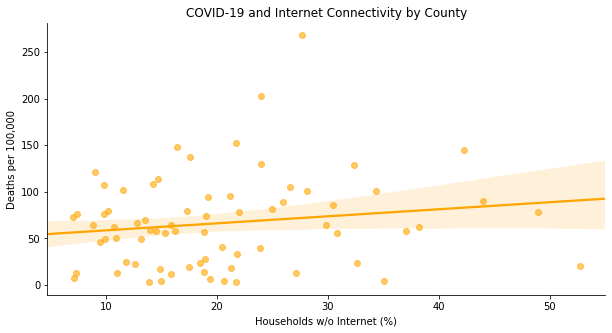

In [36]:
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

#densitiy relationship clear but doesnt look good on graph

my_kws={ 'alpha':0.6}

sns.regplot(x='Pct_NoInternet',
                                                # column to put on x axis
            y= 'Deathsp100k',                     # column to put on y axis 
            data=deaths_demographics_con,       # the data
            ax = my_ax,                         # an axis object
            color = 'Orange',  
            logx=False,
            scatter_kws = my_kws,
            ci = 90)                            # confidence interval, 0 supresses it
 


sns.despine(ax = my_ax)                             

# Since this is all in a matplotlib axis/figure, our usual labeling applies.  
my_ax.set_title('COVID-19 and Internet Connectivity by County')
my_ax.set_xlabel('Households w/o Internet (%)')
my_ax.set_ylabel('Deaths per 100,000')

plt.show()

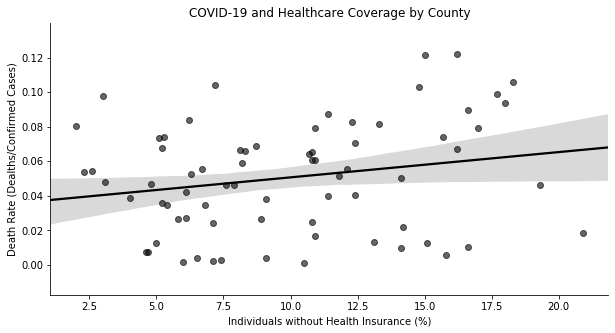

In [37]:
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

#densitiy relationship clear but doesnt look good on graph

my_kws={ 'alpha':0.6}

sns.regplot(x='Pct_NoCoverage',
                                                # column to put on x axis
            y= 'DeathRate',                     # column to put on y axis 
            data=deaths_demographics_con,       # the data
            ax = my_ax,                         # an axis object
            color = 'Black',  
            logx=False,
            scatter_kws = my_kws,
            ci = 90)                            # confidence interval, 0 supresses it

sns.despine(ax = my_ax)

                            

# Since this is all in a matplotlib axis/figure, our usual labeling applies.  
my_ax.set_title('COVID-19 and Healthcare Coverage by County')
my_ax.set_xlabel('Individuals without Health Insurance (%)')
my_ax.set_ylabel('Death Rate (Dealths/Confirmed Cases)')

plt.show()

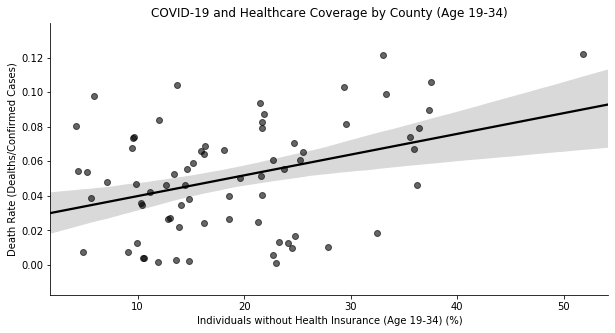

In [38]:
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

#densitiy relationship clear but doesnt look good on graph

my_kws={ 'alpha':0.6}

sns.regplot(x='Pct_NoCoverage_19to34',
                                                # column to put on x axis
            y= 'DeathRate',                     # column to put on y axis 
            data=deaths_demographics_con,       # the data
            ax = my_ax,                         # an axis object
            color = 'Black',  
            logx=False,
            scatter_kws = my_kws,
            ci = 90)                            # confidence interval, 0 supresses it
sns.despine(ax = my_ax)
                            

# Since this is all in a matplotlib axis/figure, our usual labeling applies.  
my_ax.set_title('COVID-19 and Healthcare Coverage by County (Age 19-34)')
my_ax.set_xlabel('Individuals without Health Insurance (Age 19-34) (%)')
my_ax.set_ylabel('Death Rate (Dealths/Confirmed Cases)')

plt.show()

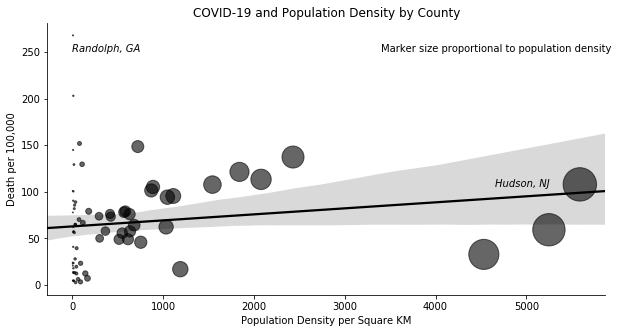

In [39]:
my_fig, my_ax = plt.subplots(figsize=(10,5)) 

my_kws={ 's': deaths_demographics_con['Density']/5,'alpha':0.6}

sns.regplot(x='Density',
                                                # column to put on x axis
            y= 'Deathsp100k',                     # column to put on y axis 
            data=deaths_demographics_con,       # the data
            ax = my_ax,                         # an axis object
            color = 'Black',  
            logx=False,
            scatter_kws = my_kws,
            ci = 90)                            # confidence interval, 0 supresses it
sns.despine(ax = my_ax)

 
my_ax.text(3400, 250, 'Marker size proportional to population density') 

my_ax.text(0, 250, 'Randolph, GA',  style="italic") 
my_ax.text(4650, 105, 'Hudson, NJ',  style="italic") 

# Since this is all in a matplotlib axis/figure, our usual labeling applies.  
my_ax.set_title('COVID-19 and Population Density by County')
my_ax.set_xlabel('Population Density per Square KM')
my_ax.set_ylabel('Death per 100,000')

plt.show()

In [40]:
deaths_demographics_con.sort_values('Density', ascending=False).head(1)

,GEOID,County,SqrKM,geometry,Province_State_x,Deaths,Cases,Population,Males,Females,...,Median_Rent,Median_Home_Value,Pct_NoComp,Pct_NoInternet,Pct_NoCoverage,Pct_NoCoverage_19to34,Density,DeathRate,Deathsp100k,Casesp100k
2951,34017,Hudson,119.632168,"POLYGON ((-8256119.128 4947355.695, -8255489.6...",New Jersey,722,14309,668631,332268,336363,...,1212.0,364100.0,10.3,14.2,14.1,19.6,5589.05695,0.050458,107.981832,2140.044359


**Regression Analysis**

In [41]:
deaths_demographics_drop.rename(columns = {'Pct_65+':'PCT65'}, inplace=True)

In [42]:
var = deaths_demographics_drop[['GEOID', 'County', 'SqrKM', 'geometry', 'Province_State_x', 'Deaths',
       'Cases', 'Population', 'Males', 'Females', 'PCT65', 'Median_Age',
       'Pct_White', 'Pct_Black', 'Pct_Asian', 'Pct_Latino', 'Household_Income',
       'Housing_Units', 'Occupied_Housing_Units', 'Home_Owernship_Rate',
       'Median_Rent', 'Median_Home_Value', 'Pct_NoComp', 'Pct_NoInternet',
       'Pct_NoCoverage', 'Pct_NoCoverage_19to34', 'Density', 'DeathRate',
       'Deathsp100k', 'Casesp100k']]
var.dropna(inplace=True)

In [43]:
#regression analysis using data for counties with deaths greater than 15 per 100,000 people

res = smf.ols(formula = 'Deaths ~ Population + Males + Females + PCT65 + Median_Age + Pct_White + Pct_Black + Pct_Asian + Pct_Latino + Household_Income + Housing_Units + Occupied_Housing_Units + Home_Owernship_Rate + Median_Rent + Median_Home_Value +Pct_NoComp+Pct_NoInternet +Pct_NoCoverage + Pct_NoCoverage_19to34 + Density', data=var).fit()
print(res.summary()) 

                            OLS Regression Results                            
Dep. Variable:                 Deaths   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     47.08
Date:                Fri, 01 May 2020   Prob (F-statistic):           3.71e-76
Time:                        20:32:51   Log-Likelihood:                -1870.3
No. Observations:                 304   AIC:                             3781.
Df Residuals:                     284   BIC:                             3855.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -233

In [44]:
corr = deaths_demographics_drop.corr()
corr.style.background_gradient(cmap='coolwarm')

,GEOID,SqrKM,Deaths,Cases,Population,Males,Females,PCT65,Median_Age,Pct_White,Pct_Black,Pct_Asian,Pct_Latino,Household_Income,Housing_Units,Occupied_Housing_Units,Home_Owernship_Rate,Median_Rent,Median_Home_Value,Pct_NoComp,Pct_NoInternet,Pct_NoCoverage,Pct_NoCoverage_19to34,Density,DeathRate,Deathsp100k,Casesp100k
GEOID,1,-0.0913775,0.0833208,0.101898,0.0911744,0.0918919,0.0904791,0.0571051,0.0583863,0.0469978,-0.150283,0.143311,0.130285,0.183878,0.0879572,0.0906628,0.0207061,0.172678,0.097736,-0.151556,-0.163147,-0.148764,-0.122459,0.111026,0.111144,-0.107658,-0.0535198
SqrKM,-0.0913775,1,-0.0577267,-0.0528073,-0.0188803,-0.0173894,-0.0202879,-0.0166023,-0.116584,-0.0613169,-0.174079,-0.0678343,0.160881,-0.0406263,-0.0169021,-0.0217742,0.0191014,0.0341766,0.0296776,0.0395399,0.052767,0.0735106,0.0151938,-0.119812,0.113575,-0.102659,-0.057647
Deaths,0.0833208,-0.0577267,1,0.933239,0.791272,0.789972,0.79236,-0.219616,-0.137638,-0.206253,-0.0273967,0.569764,0.359613,0.432346,0.776203,0.773532,-0.289753,0.562189,0.524047,-0.304106,-0.326536,-0.209209,-0.235933,0.568294,-0.137207,0.380584,0.514319
Cases,0.101898,-0.0528073,0.933239,1,0.779168,0.778263,0.779884,-0.205927,-0.135112,-0.208683,-0.0393039,0.538028,0.400358,0.436806,0.754726,0.752802,-0.26529,0.576075,0.540423,-0.285596,-0.308577,-0.189533,-0.216934,0.578743,-0.154485,0.338678,0.57599
Population,0.0911744,-0.0188803,0.791272,0.779168,1,0.999903,0.999913,-0.268609,-0.193303,-0.17519,-0.051622,0.583527,0.321666,0.424119,0.996944,0.998246,-0.308421,0.540648,0.478023,-0.354837,-0.376022,-0.261048,-0.295054,0.530825,-0.161298,0.0982688,0.236457
Males,0.0918919,-0.0173894,0.789972,0.778263,0.999903,1,0.999632,-0.269834,-0.193463,-0.173546,-0.0545756,0.586161,0.323274,0.426729,0.996603,0.998171,-0.306954,0.542473,0.480009,-0.35668,-0.377883,-0.261834,-0.29604,0.527755,-0.161399,0.0972976,0.236089
Females,0.0904791,-0.0202879,0.79236,0.779884,0.999913,0.999632,1,-0.267402,-0.193117,-0.176714,-0.0488176,0.58093,0.320087,0.421574,0.997088,0.998139,-0.309754,0.538825,0.476059,-0.353029,-0.374194,-0.260257,-0.294068,0.533636,-0.161173,0.0991704,0.236762
PCT65,0.0571051,-0.0166023,-0.219616,-0.205927,-0.268609,-0.269834,-0.267402,1,0.903121,0.330285,-0.122271,-0.313878,-0.293829,-0.248463,-0.251167,-0.263428,0.427116,-0.306874,-0.222257,0.289365,0.24669,0.000301628,0.134466,-0.300601,0.3857,-0.078861,-0.22176
Median_Age,0.0583863,-0.116584,-0.137638,-0.135112,-0.193303,-0.193463,-0.193117,0.903121,1,0.396214,-0.180128,-0.205271,-0.305353,-0.0279086,-0.181658,-0.190416,0.522191,-0.137917,-0.054973,0.113021,0.0767114,-0.163921,-0.0241105,-0.272093,0.298702,-0.071236,-0.179673
Pct_White,0.0469978,-0.0613169,-0.206253,-0.208683,-0.17519,-0.173546,-0.176714,0.330285,0.396214,1,-0.807699,-0.182099,-0.269742,0.258403,-0.168289,-0.167807,0.542926,-0.0088084,0.0379739,-0.35673,-0.391018,-0.531608,-0.496835,-0.286646,0.210342,-0.315102,-0.342146


In [45]:
deaths_demographics_drop2.rename(columns = {'Pct_65+':'PCT65'}, inplace=True)

In [46]:
var = deaths_demographics_drop2[['GEOID', 'County', 'SqrKM', 'geometry', 'Province_State_x', 'Deaths',
       'Cases', 'Population', 'Males', 'Females', 'PCT65', 'Median_Age',
       'Pct_White', 'Pct_Black', 'Pct_Asian', 'Pct_Latino', 'Household_Income',
       'Housing_Units', 'Occupied_Housing_Units', 'Home_Owernship_Rate',
       'Median_Rent', 'Median_Home_Value', 'Pct_NoComp', 'Pct_NoInternet',
       'Pct_NoCoverage', 'Pct_NoCoverage_19to34', 'Density', 'DeathRate',
       'Deathsp100k', 'Casesp100k']]
var.dropna(inplace=True)

In [47]:
#regression analysis using data for counties with confimred cases greater than 750 per 100,000 people

res = smf.ols(formula = 'Deaths ~ Population + Males + Females + PCT65 + Median_Age + Pct_White + Pct_Black + Pct_Asian + Pct_Latino + Household_Income + Housing_Units + Occupied_Housing_Units + Home_Owernship_Rate + Median_Rent + Median_Home_Value +Pct_NoComp+Pct_NoInternet +Pct_NoCoverage + Pct_NoCoverage_19to34 + Density', data=var).fit()
print(res.summary()) 

                            OLS Regression Results                            
Dep. Variable:                 Deaths   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     20.00
Date:                Fri, 01 May 2020   Prob (F-statistic):           8.69e-20
Time:                        20:32:52   Log-Likelihood:                -525.92
No. Observations:                  83   AIC:                             1092.
Df Residuals:                      63   BIC:                             1140.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -269

**Choropleths**

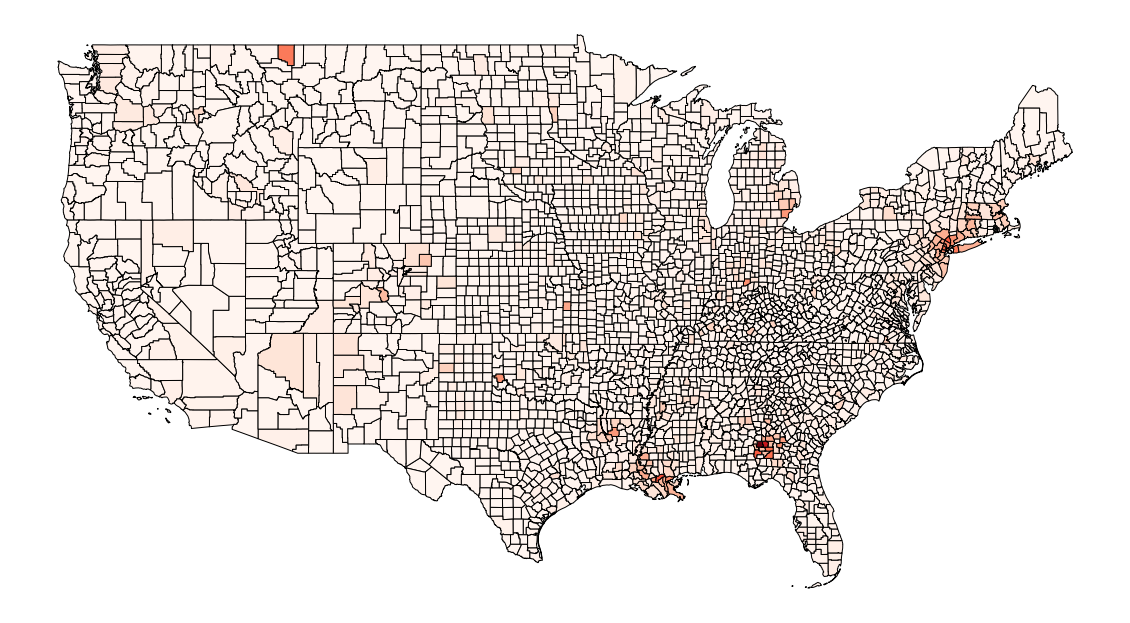

In [48]:
fig, gax = plt.subplots(figsize=(20,40))

deaths_demographics_minusny.plot(ax=gax, edgecolor='black', column='Deathsp100k',  legend=False, cmap='Reds')

plt.axis('off')

plt.show()

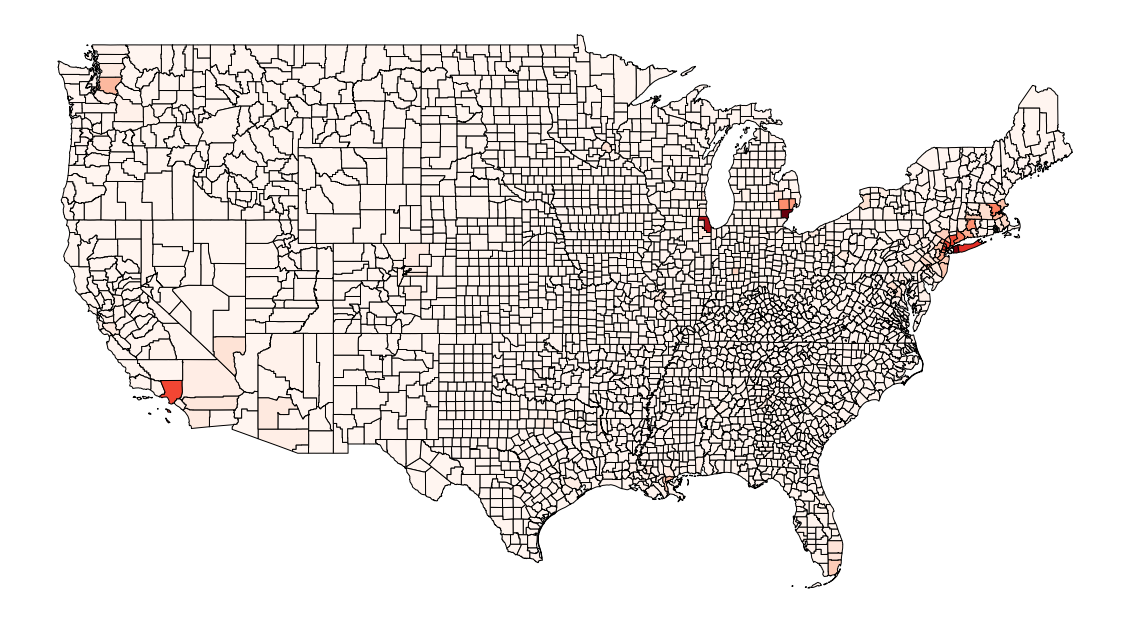

In [49]:
fig, gax = plt.subplots(figsize=(20,40))

deaths_demographics_minusny.plot(ax=gax, edgecolor='black', column='Deaths',  legend=False, cmap='Reds')

plt.axis('off')

plt.show()